### XGBoost Remind

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

### Metrics Method

In [3]:
def metrics(y_test, pred):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_score = roc_auc_score(y_test, pred)
    print("정확도: {0:2f}, 정밀도: {1:2f}, 재현율 {2:2f}".format(accuracy, precision, recall))
    print('f1-score : {0:.2f}, auc : {1:.2f}'.format(f1, roc_score))

### Data Load & Preprocessing

In [4]:
# train = pd.read_csv('/Users/yoo/Data-dev/etc/practice_algorithm/datasets/titanic_train.csv')
# test = pd.read_csv('/Users/yoo/Data-dev/etc/practice_algorithm/datasets/titanic_test.csv')

# Colab
train = pd.read_csv('/content/titanic_train.csv')
test = pd.read_csv('/content/titanic_test.csv')

print(train.shape, test.shape)
train.head(5)

(891, 12) (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
train['Name'].str.extract('([A-Za-z]+)\.')

,0
0,Mr
1,Mrs
2,Miss
3,Mrs
4,Mr
...,...
886,Rev
887,Miss
888,Miss
889,Mr


In [15]:
train['Embarked'].fillna('S', inplace=True)
train['Fare'].fillna(0, inplace=True)
train['Initial'] = train['Name'].str.extract('([A-Za-z]+)\.')

train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Mr
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,Mr
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,Master
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,Mrs
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,Mrs


In [16]:
mapping = {
    "Mr":0,
    "Miss":1,
    "Mrs":1,
    "Master":2,
    "Other":3
}

mapping_sex = {
    'male': 0,
    'female': 1
}

mapping_em = {
    'S': 0,
    'C': 1,
    'Q': 2
}

In [17]:
train['Initial'] = train['Initial'].map(mapping)
train['Fare'] = train['Fare'].map(lambda x: np.log(x) if x > 0 else 0)
train['Sex'] = train['Sex'].map(mapping_sex)
train['Embarked'] = train['Embarked'].map(mapping_em)

train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,1.981001,NaN,0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,4.266662,C85,1,1.0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,3.972177,C123,0,1.0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,2.085672,NaN,0,0.0
5,6,0,3,"Moran, Mr. James",0,NaN,0,0,330877,2.135148,NaN,2,0.0
6,7,0,1,"McCarthy, Mr. Timothy J",0,54.0,0,0,17463,3.948596,E46,0,0.0
7,8,0,3,"Palsson, Master. Gosta Leonard",0,2.0,3,1,349909,3.048088,NaN,0,2.0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,27.0,0,2,347742,2.409941,NaN,0,1.0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,14.0,1,0,237736,3.403555,NaN,1,1.0


In [18]:
train.drop(['PassengerId', 'Ticket', 'Cabin', 'Name'], axis=1, inplace=True)

train.loc[(train['Age'].isnull()) & (train['Initial'] == 0), 'Age'] = 32
train.loc[(train['Age'].isnull()) & (train['Initial'] == 1), 'Age'] = 28
train.loc[(train['Age'].isnull()) & (train['Initial'] == 2), 'Age'] = 5
train.loc[(train['Age'].isnull()) & (train['Initial'] == 3), 'Age'] = 45

train.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Initial
0,0,3,0,22.0,1,0,1.981001,0,0.0
1,1,1,1,38.0,1,0,4.266662,1,1.0
2,1,3,1,26.0,0,0,2.070022,0,1.0
3,1,1,1,35.0,1,0,3.972177,0,1.0
4,0,3,0,35.0,0,0,2.085672,0,0.0
5,0,3,0,32.0,0,0,2.135148,2,0.0
6,0,1,0,54.0,0,0,3.948596,0,0.0
7,0,3,0,2.0,3,1,3.048088,0,2.0
8,1,3,1,27.0,0,2,2.409941,0,1.0
9,1,2,1,14.0,1,0,3.403555,1,1.0


In [19]:
x = train.drop('Survived', axis = 1)
y = train['Survived']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=9095)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(668, 8) (223, 8) (668,) (223,)


In [26]:
%%time

xgb = XGBClassifier()

xgb_param_grid = {
    'n_estimators': [100, 200, 400, 600],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [4, 6, 8, 10, 12],
}

xgb_grid = GridSearchCV(xgb, param_grid=xgb_param_grid, scoring='roc_auc', n_jobs = -1)
xgb_grid.fit(x_train, y_train)

CPU times: user 1.94 s, sys: 60.2 ms, total: 2 s
Wall time: 44 s


In [21]:
print("최고 평균 파라미터: {0:4f}".format(xgb_grid.best_score_))
print("Best Param: ", xgb_grid.best_params_)

최고 평균 파라미터: 0.870945
Best Param:  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200}


In [22]:
result = pd.DataFrame(xgb_grid.cv_results_)
result.sort_values(by=['rank_test_score'], inplace=True)

In [23]:
result[['params', 'mean_test_score', 'rank_test_score']].head(10)

,params,mean_test_score,rank_test_score
1,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",0.870945,1
2,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",0.869960,2
20,"{'learning_rate': 0.05, 'max_depth': 4, 'n_est...",0.868878,3
3,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",0.867438,4
40,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.865256,5
4,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est...",0.865185,6
21,"{'learning_rate': 0.05, 'max_depth': 4, 'n_est...",0.862349,7
5,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est...",0.861251,8
0,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",0.860114,9
6,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est...",0.859694,10


In [24]:
xgb = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth=3)
evals = [(x_test, y_test)]
xgb.fit(x_train, y_train, early_stopping_rounds = 100, eval_metric = 'logloss', eval_set=evals, verbose=1)

[0]	validation_0-logloss:0.649124
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.614501
[2]	validation_0-logloss:0.584465
[3]	validation_0-logloss:0.5594
[4]	validation_0-logloss:0.539796
[5]	validation_0-logloss:0.522108
[6]	validation_0-logloss:0.508318
[7]	validation_0-logloss:0.495505
[8]	validation_0-logloss:0.484369
[9]	validation_0-logloss:0.477591
[10]	validation_0-logloss:0.471199
[11]	validation_0-logloss:0.464968
[12]	validation_0-logloss:0.460617
[13]	validation_0-logloss:0.45637
[14]	validation_0-logloss:0.454156
[15]	validation_0-logloss:0.450471
[16]	validation_0-logloss:0.44773
[17]	validation_0-logloss:0.446812
[18]	validation_0-logloss:0.444668
[19]	validation_0-logloss:0.443196
[20]	validation_0-logloss:0.442452
[21]	validation_0-logloss:0.440883
[22]	validation_0-logloss:0.440724
[23]	validation_0-logloss:0.439543
[24]	validation_0-logloss:0.440105
[25]	validation_0-logloss:0.438317
[26]	validation_0-logloss:0.437349


XGBClassifier(n_estimators=400)

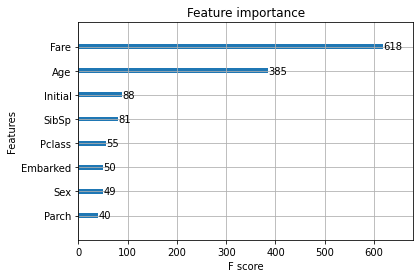

In [25]:
fig, ax = plt.subplots()
plot_importance(xgb, ax=ax)